# Quantitative Spatial Economics 

## Tutorial Topic 1: Rosen-Roback

Humboldt University Berlin & Berlin School of Economics

Authors:
[Dominik Bursy](mailto:dominik.bursy@icloud.com),
[Lars Felder](),
[Marlon Krippendorf]()

Last Update: April 2024

---

In Topic 1, we covered the Rosen-Roback framework during the lecture. In this tutorial, we apply the logic of the spatial equilibrium framework to compute a quality-of-
life (QoL) ranking for Germany counties (Kreise & kreisfreie Städte).

---

## Table of Contents

- [Import Packages](#packages)
- [Import Datasets](#data_import)
- [1. Average Wage](#average_wage)
- [2. House Price Index](#house_price_index)
- [3. Exogenous Factors](#exogenous_factors)
- [Appendix](#appendix)

## Import Packages <a class="anchor" id="packages"></a>

In [29]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS 
# from tabulate import tabulate

import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

## Document Options
savefigures = False
# pd.set_option('display.max_columns', None)

In [30]:
## Set Root Directory

ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration


## Import Datasets <a class="anchor" id="data_import"></a>

In [31]:
## Shapefile of German Counties

gdf_germany_counties = gpd.read_file(f'{ROOT_FOLDER}/data/Shapefiles-2022/Germany/COUNTIES/VG250_KRS_clean_final.shp')
gdf_germany_counties = gdf_germany_counties[['county_id', 'GEN', 'EWZ', 'KFL', 'geometry']] 
gdf_germany_counties.rename(columns={'GEN': 'county_name', 'EWZ': 'population', 'KFL': 'county_area'}, inplace=True) 

In [32]:
## Shapefile of German State

url = 'https://daten.gdz.bkg.bund.de/produkte/vg/vg2500/aktuell/vg2500_12-31.utm32s.shape.zip'
filename = 'vg2500_12-31.utm32s.shape/vg2500/VG2500_LAN.shp'

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

gdf_germany_states = gpd.read_file(filename, sep=',')
gdf_germany_states = gdf_germany_states.loc[:,['GEN', 'geometry']].rename(columns={'GEN':'state_name'})
gdf_germany_states = gdf_germany_states.iloc[:16]

## Add State Information to German Counties 
# gdf_germany_counties = gdf_germany_counties.sjoin(gdf_germany_states).drop(['index_right'], axis=1)

In [33]:
## Points of German Cities

df_germany_cities = pd.read_csv('https://simplemaps.com/static/data/country-cities/de/de.csv')

gdf_germany_cities = gpd.GeoDataFrame(
    df_germany_cities, geometry=gpd.points_from_xy(df_germany_cities.lng, df_germany_cities.lat), crs="EPSG:4326"
).to_crs(25832)

gdf_germany_cities_large = gdf_germany_cities.iloc[:14,:]

In [34]:
## Wage and Employment data of the German Federal Employment Agency

url = 'https://statistik.arbeitsagentur.de/Statistikdaten/Detail/202312/iiia6/beschaeftigung-entgelt-entgelt/entgelt-dwolk-0-202312-xlsx.xlsx;jsessionid=F902B9525AC5A2D0A04F98862929A3B1?__blob=publicationFile&v=2'

df_wages = pd.read_excel(f'{ROOT_FOLDER}/data/county-wages-2022/country-wages-2022-entgelt-dwolk-0-202212-xlsx (1).xlsx',
              sheet_name='8.1', header=9)

df_wages = pd.read_excel(url,
              sheet_name='8.1', header=9)

## Task 1: Wage and Employment across Germany <a class="anchor" id="average_wage"></a>

In [35]:
## Wage and Employment data of the German Federal Employment Agency

df_wages = pd.read_excel(f'{ROOT_FOLDER}/data/county-wages-2022/country-wages-2022-entgelt-dwolk-0-202212-xlsx (1).xlsx',
              sheet_name='8.1', header=9)

## Extract wages and number of workers for workers 

# i) without professional qualification(ohne Berufsabschluss)
gdf_germany_counties = gdf_germany_counties.join(
    df_wages.loc[df_wages['Unnamed: 2'] == 'ohne Berufsabschluss', ['Unnamed: 0', 1, 8]].set_index('Unnamed: 0'), 
    on='county_id').rename(columns={1: 'workers_no_qualification', 8: 'wage_no_qualification'})

# ii)with recognized professional qualification (anerkannter Berufsabschluss)
gdf_germany_counties = gdf_germany_counties.join(
    df_wages.loc[df_wages['Unnamed: 2'] == 'anerkannter Berufsabschluss', ['Unnamed: 0', 1, 8]].set_index('Unnamed: 0'), 
    on='county_id').rename(columns={1: 'workers_professional', 8: 'wage_professional'})

# iii) with academic degree (akademischer Berufsabschluss)
gdf_germany_counties = gdf_germany_counties.join(
    df_wages.loc[df_wages['Unnamed: 2'] == 'akademischer Berufsabschluss', ['Unnamed: 0', 1, 8]].set_index('Unnamed: 0'), 
    on='county_id').rename(columns={1: 'workers_academic', 8: 'wage_academic'})

## Clean Wage and Employment data

gdf_germany_counties.replace('X', np.nan, inplace=True)
gdf_germany_counties.replace('> 7.050', 7050, inplace=True)
gdf_germany_counties.iloc[:,5:] = gdf_germany_counties.iloc[:,5:].astype('float')

## Create lists of Skill Groups

list_workers_skill_groups = ['workers_no_qualification', 'workers_professional', 'workers_academic']
list_wage_skill_groups = ['wage_no_qualification', 'wage_professional', 'wage_academic']

### Descriptive Statistics Employment across Germany

In [36]:
print(tabulate(
    gdf_germany_counties[list_workers_skill_groups].describe(),
    headers=['Workers', 'No Qualification', 'Professional', 'Academic'], tablefmt='orgtbl'))

| Workers   |   No Qualification |   Professional |   Academic |
|-----------+--------------------+----------------+------------|
| count     |             400    |          400   |      400   |
| mean      |            4651.64 |        34476.9 |    11531.5 |
| std       |            6485.95 |        39289.4 |    29205.1 |
| min       |             354    |         5092   |      641   |
| 25%       |            1732.75 |        16472   |     2690   |
| 50%       |            2848    |        24859   |     4755.5 |
| 75%       |            5459.5  |        38817.8 |     9950.5 |
| max       |           73456    |       475713   |   360929   |


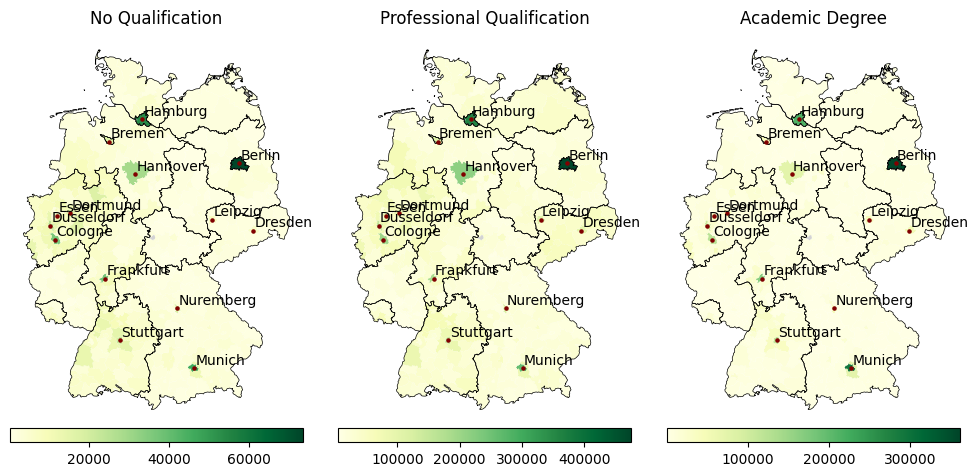

In [37]:
figure, axis = plt.subplots(1, 3, figsize=(10, 10)) 

list_display = ['No Qualification', 'Professional Qualification', 'Academic Degree']

for skill_group in list_workers_skill_groups:
    axis_index = list_workers_skill_groups.index(skill_group)
    gdf_germany_counties.plot(column=skill_group, cmap='YlGn', ax=axis[axis_index], 
                              #scheme="quantiles",
                              legend=True, legend_kwds={'orientation':'horizontal', "pad": 0},
                              missing_kwds={"color": "lightgrey", "label": "Missing values"})
    
    gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis[axis_index])
    gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis[axis_index])

    for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
        ax=axis[axis_index].annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)
    
    ax=axis[axis_index].set_title(list_display[axis_index])
    ax=axis[axis_index].set_axis_off()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/germany_employment.png', bbox_inches='tight')
else:
    plt.tight_layout()

### Descriptive Statistics Wages across Germany

In [38]:
print(tabulate(
    gdf_germany_counties[list_wage_skill_groups].describe(),
    headers=['Wages', 'No Qualification', 'Professional', 'Academic'], tablefmt='orgtbl'))

| Wages   |   No Qualification |   Professional |   Academic |
|---------+--------------------+----------------+------------|
| count   |            396     |        400     |    400     |
| mean    |           2627.04  |       3436.1   |   5178.3   |
| std     |            238.413 |        377.625 |    581.128 |
| min     |           2145.27  |       2576.14  |   4044.25  |
| 25%     |           2470.09  |       3254.59  |   4736.78  |
| 50%     |           2635.93  |       3460.88  |   5089.03  |
| 75%     |           2776.48  |       3648.54  |   5469.77  |
| max     |           3378.25  |       4908.91  |   7050     |


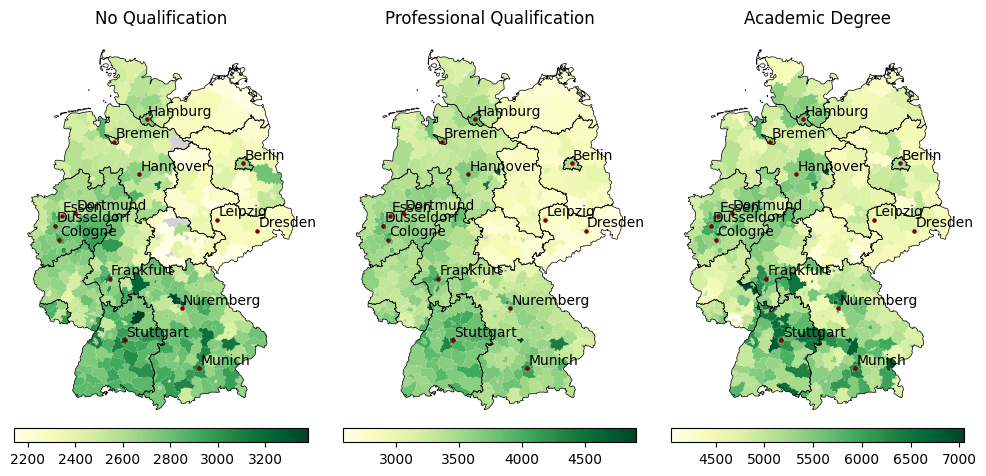

In [39]:
figure, axis = plt.subplots(1, 3, figsize=(10, 10)) 

list_display = ['No Qualification', 'Professional Qualification', 'Academic Degree']


for skill_group in list_wage_skill_groups:
    axis_index = list_wage_skill_groups.index(skill_group)
    gdf_germany_counties.plot(column=skill_group, cmap='YlGn', ax=axis[axis_index],
                              legend=True, legend_kwds={'orientation':'horizontal', "pad": 0},
                              missing_kwds={"color": "lightgrey", "label": "Missing values"})
    gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis[axis_index])
    gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis[axis_index])

    for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
        ax=axis[axis_index].annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)
    
    ax=axis[axis_index].set_title(list_display[axis_index])
    ax=axis[axis_index].set_axis_off()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/germany_wages.png', bbox_inches='tight')
else:
    plt.tight_layout()

### Comments 

- Wages are top censored $\Rightarrow$ We see less heterogeneity, inequality underestimated 

---

## Task 2: Mix-Adjusted House Price Index <a class="anchor" id="house_price_index"></a>

The standard way of creating a mix-adjusted price index is to adjust for observable characteristics in an “hedonic” regressions and recover fixed effects for the spatial units of interest:

$$
price_{ic} = \beta_1 + \beta_2 constructionyear_{ic} + \beta_3 floor_{ic} + \beta_4 rooms_{ic} + \beta_5 kitchen_{ic} + \beta_6 parking_{ic} + \beta_7 elevator_{ic} + \gamma_{c} + \epsilon_{ic}
$$

### Rent Price Index

In [40]:
## Load the RWI-FDZ cross-section data on rental prices and purchase prices
df_campus_wm = pd.read_csv(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/cross_section/CampusFile_WM_2022.csv', low_memory=False)

## Inspect the data set
df_campus_wm.head() 

,obid,plz,mietekalt,nebenkosten,heizkosten,baujahr,letzte_modernisierung,wohnflaeche,nutzflaeche,etage,...,bef3,anbieter,hits_gen,click_schnellkontakte_gen,click_weitersagen_gen,click_url_gen,liste_show_gen,liste_match_gen,adat,rent_sqm
0,134064657,24937,455.0,111,Other missing,NaN,Other missing,63.000000,Other missing,0,...,Other missing,Private offer,0.00000,0.000000,0.000000,0.000000,0.0000,0.0000,2022m5,7.222222
1,138475785,24937,380.0,85,95,NaN,Other missing,58.369999,Other missing,1,...,Other missing,Housing industry,65.25000,1.750000,0.000000,0.000000,1185.3125,3966.5625,2022m12,6.510194
2,136775842,24943,460.0,95,110,1980.0,Other missing,59.000000,Other missing,1,...,Other missing,Real-estate agent,108.94118,4.294117,0.000000,0.176471,1746.0588,4761.0000,2022m9,7.796610
3,91272177,24937,726.0,160,160,NaN,Other missing,80.650002,30,2,...,Other missing,Housing industry,968.23938,10.207627,0.099576,0.830508,19213.1190,59511.5040,2022m6,9.001860
4,138300121,24941,440.0,210,105,1955.0,Other missing,57.049999,Other missing,1,...,Other missing,Builder,110.06667,5.066667,0.000000,0.000000,1684.8667,4382.2002,2022m12,7.712533


In [41]:
## Select and prepare relevant characteristics 
df_campus_wm_clean = df_campus_wm.copy(deep=True)

df_campus_wm_clean['rent_sqm'] = np.log(df_campus_wm_clean['rent_sqm'])

# Year of construction 
df_campus_wm_clean.loc[df_campus_wm_clean['baujahr'].isna(), 'baujahr'] = df_campus_wm_clean['baujahr'].median()

# Number of Floor
df_campus_wm_clean.loc[df_campus_wm_clean['etage'] == 'Other missing', 'etage'] = np.nan
df_campus_wm_clean.loc[df_campus_wm_clean['etage'] == 'Implausible value', 'etage'] = np.nan
df_campus_wm_clean.loc[df_campus_wm_clean['etage'] == '44141.0', 'etage'] = np.nan
df_campus_wm_clean.loc[df_campus_wm_clean['etage'].isna()] = df_campus_wm_clean['etage'].median()
df_campus_wm_clean['etage'] = df_campus_wm_clean['etage'].astype(float)
df_campus_wm_clean['etage_squared'] = df_campus_wm_clean['etage']**2

# Number of Rooms
df_campus_wm_clean.loc[df_campus_wm_clean['zimmeranzahl'] == 'Implausible value', 'zimmeranzahl'] = np.nan
df_campus_wm_clean.loc[df_campus_wm_clean['zimmeranzahl'].isna(), 'zimmeranzahl'] = df_campus_wm_clean['zimmeranzahl'].median()
df_campus_wm_clean['zimmeranzahl'] = df_campus_wm_clean['zimmeranzahl'].astype(float)
df_campus_wm_clean['zimmeranzahl_squared'] = df_campus_wm_clean['zimmeranzahl']**2

# Postal Code
df_campus_wm_clean.loc[df_campus_wm_clean['plz'] == 'Other missing', 'plz'] = np.nan
df_campus_wm_clean.loc[df_campus_wm_clean['plz'].isna(), 'plz'] = df_campus_wm_clean['plz'].median()
df_campus_wm_clean['plz'] = df_campus_wm_clean['plz'].astype(float)

## Balcony
df_campus_wm_clean.loc[df_campus_wm_clean['balkon'] == 'Other missing', 'balkon'] = np.nan
df_campus_wm_clean['balkon'] = pd.get_dummies(df_campus_wm_clean['balkon'], drop_first=True)['Yes']

## Built-in Kitchen
df_campus_wm_clean.loc[df_campus_wm_clean['einbaukueche'] == 'Other missing', 'einbaukueche'] = np.nan
df_campus_wm_clean['einbaukueche'] = pd.get_dummies(df_campus_wm_clean['einbaukueche'], drop_first=True)['Yes']

## Parking Lot
df_campus_wm_clean.loc[df_campus_wm_clean['parkplatz'] == 'Other missing', 'parkplatz'] = np.nan
df_campus_wm_clean['parkplatz'] = pd.get_dummies(df_campus_wm_clean['parkplatz'], drop_first=True)['Yes']

## Elevator
df_campus_wm_clean.loc[df_campus_wm_clean['aufzug'] == 'Other missing', 'aufzug'] = np.nan
df_campus_wm_clean['aufzug'] = pd.get_dummies(df_campus_wm_clean['aufzug'], drop_first=True)['Yes']

In [42]:
## Set target, features and fixed effects

target = ['rent_sqm'] # Rent per square-meter: mietekalt / wohnflaeche
features = ['baujahr', 'etage', 'zimmeranzahl', 'einbaukueche', 'parkplatz', 'aufzug']
fixed_effects = ['kid2019']

## Subset dataframe, drop missing values and index as panel dataset
data_regression = df_campus_wm_clean[target + features + fixed_effects].dropna()
data_regression = data_regression.set_index(fixed_effects + [data_regression.index])

## Set dependent and explainatory variables 
Y = data_regression[target]
X = data_regression[features]
#X = sm.add_constant(X)

## Estimation of the firm fixed effects model
panel_ols_model = PanelOLS(Y, X, entity_effects=True, time_effects=False)
results_panel_ols_model = panel_ols_model.fit()
print(results_panel_ols_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:               rent_sqm   R-squared:                        0.1364
Estimator:                   PanelOLS   R-squared (Between):              0.7177
No. Observations:              371103   R-squared (Within):               0.1364
Date:                Fri, Apr 25 2025   R-squared (Overall):              0.5907
Time:                        14:21:57   Log-likelihood                  9.26e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      9760.8
Entities:                         381   P-value                           0.0000
Avg Obs:                       974.02   Distribution:                F(6,370716)
Min Obs:                       23.000                                           
Max Obs:                    6.079e+04   F-statistic (robust):             9760.8
                            

In [43]:
## Retrieve coefficients of firm fixed effects
df_fixed_effects = results_panel_ols_model.estimated_effects.reset_index().drop(columns='time').drop_duplicates(subset=['kid2019'])
df_fixed_effects['kid2019'] = df_fixed_effects['kid2019'].astype('object')

df_fixed_effects.rename(columns={'estimated_effects': 'rent_index'}, inplace=True)

gdf_germany_counties['county_id'] = gdf_germany_counties['county_id'].astype('float')
gdf_germany_counties = gdf_germany_counties.join(df_fixed_effects.set_index('kid2019'), on='county_id')

def normalize_min_max(df_column):
    return (df_column - df_column.min()) / (df_column.max() - df_column.min())
    
gdf_germany_counties['rent_index'] = normalize_min_max(gdf_germany_counties['rent_index'])

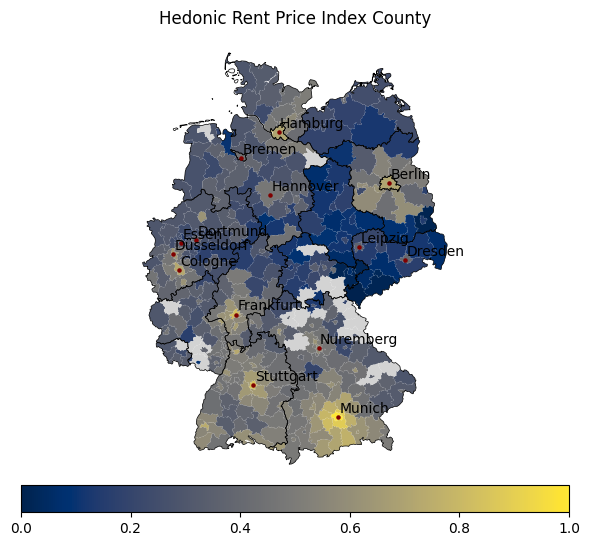

In [44]:
figure, axis = plt.subplots(1, 1, figsize=(6, 6)) 

gdf_germany_counties.plot(column='rent_index', cmap='cividis',ax=axis, 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"}, # "edgecolor": "red", "hatch": "///", 
                          #scheme="quantiles", legend=True, legend_kwds=dict(loc='lower left', bbox_to_anchor=(0.05,-0.2), 
                          #ncol=2))
                          legend=True, legend_kwds={'orientation':'horizontal', "pad": 0})

gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis)

gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis)

for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Hedonic Rent Price Index County')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/rent_index.png', bbox_inches='tight')
else:
    plt.tight_layout()

### Comments 

- [Mincer earnings equation](#https://en.wikipedia.org/wiki/Mincer_earnings_function) as an example for an hedonic price index 
- Fixed effects cleaned for observable characteristics
- Relative measure since one fixed effect is dropped (Flensburg), prices relative to Flensburg (dummy variable trap)

---

### Purchase Price Index

In [45]:
df_campus_wk = pd.read_csv(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/cross_section/CampusFile_WK_2022.csv', low_memory=False)

In [46]:
## Select and prepare relevant characteristics 
df_campus_clean = df_campus_wk.copy(deep=True)

# Year of construction 
df_campus_clean.loc[df_campus_clean['baujahr'].isna(), 'baujahr'] = df_campus_clean['baujahr'].median()

# Number of Floor
df_campus_clean.loc[df_campus_clean['etage'] == 'Other missing', 'etage'] = np.nan
df_campus_clean.loc[df_campus_clean['etage'] == 'Implausible value', 'etage'] = np.nan
df_campus_clean.loc[df_campus_clean['etage'] == '44141.0', 'etage'] = np.nan
df_campus_clean.loc[df_campus_clean['etage'].isna()] = df_campus_clean['etage'].median()
df_campus_clean['etage'] = df_campus_clean['etage'].astype(float)
df_campus_clean['etage_squared'] = df_campus_clean['etage']**2

# Number of Rooms
df_campus_clean.loc[df_campus_clean['zimmeranzahl'] == 'Implausible value', 'zimmeranzahl'] = np.nan
df_campus_clean.loc[df_campus_clean['zimmeranzahl'].isna(), 'zimmeranzahl'] = df_campus_clean['zimmeranzahl'].median()
df_campus_clean['zimmeranzahl'] = df_campus_clean['zimmeranzahl'].astype(float)
df_campus_clean['zimmeranzahl_squared'] = df_campus_clean['zimmeranzahl']**2

# Postal Code
df_campus_clean.loc[df_campus_clean['plz'] == 'Other missing', 'plz'] = np.nan
df_campus_clean.loc[df_campus_clean['plz'].isna(), 'plz'] = df_campus_clean['plz'].median()
df_campus_clean['plz'] = df_campus_clean['plz'].astype(float)

## Balcony
df_campus_clean.loc[df_campus_clean['balkon'] == 'Other missing', 'balkon'] = np.nan
df_campus_clean['balkon'] = pd.get_dummies(df_campus_clean['balkon'], drop_first=True)['Yes']

## Built-in Kitchen
df_campus_clean.loc[df_campus_clean['einbaukueche'] == 'Other missing', 'einbaukueche'] = np.nan
df_campus_clean['einbaukueche'] = pd.get_dummies(df_campus_clean['einbaukueche'], drop_first=True)['Yes']

## Parking Lot
df_campus_clean.loc[df_campus_clean['parkplatz'] == 'Other missing', 'parkplatz'] = np.nan
df_campus_clean['parkplatz'] = pd.get_dummies(df_campus_clean['parkplatz'], drop_first=True)['Yes']

## Elevator
df_campus_clean.loc[df_campus_clean['aufzug'] == 'Other missing', 'aufzug'] = np.nan
df_campus_clean['aufzug'] = pd.get_dummies(df_campus_clean['aufzug'], drop_first=True)['Yes']

In [47]:
## Set target, features and fixed effects

target = ['price_sqm'] # Rent per square-meter: mietekalt / wohnflaeche
features = ['baujahr', 'etage', 'zimmeranzahl', 'einbaukueche', 'parkplatz', 'aufzug']
fixed_effects = ['kid2019']

## Subset dataframe, drop missing values and index as panel dataset
data_regression = df_campus_clean[target + features + fixed_effects]
data_regression = data_regression.set_index(fixed_effects + [data_regression.index])

## Set dependent and explainatory variables 
Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

## Estimation of the firm fixed effects model
panel_ols_model = PanelOLS(Y, X, entity_effects=True, time_effects=False)
results_panel_ols_model = panel_ols_model.fit()
print(results_panel_ols_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:              price_sqm   R-squared:                        0.0951
Estimator:                   PanelOLS   R-squared (Between):             -7.6768
No. Observations:              149747   R-squared (Within):               0.0951
Date:                Fri, Apr 25 2025   R-squared (Overall):             -1.2477
Time:                        14:22:02   Log-likelihood                -1.254e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2616.1
Entities:                         328   P-value                           0.0000
Avg Obs:                       456.55   Distribution:                F(6,149413)
Min Obs:                       16.000                                           
Max Obs:                    4.969e+04   F-statistic (robust):             2616.1
                            

In [48]:
## Retrieve coefficients of firm fixed effects
df_fixed_effects = results_panel_ols_model.estimated_effects.reset_index().drop(columns='time').drop_duplicates(subset=['kid2019'])
df_fixed_effects['kid2019'] = df_fixed_effects['kid2019'].astype('object')

df_fixed_effects.rename(columns={'estimated_effects': 'purchase_index'}, inplace=True)

gdf_germany_counties['county_id'] = gdf_germany_counties['county_id'].astype('float')
gdf_germany_counties = gdf_germany_counties.join(df_fixed_effects.set_index('kid2019'), on='county_id')

gdf_germany_counties['purchase_index'] = normalize_min_max(gdf_germany_counties['purchase_index'])

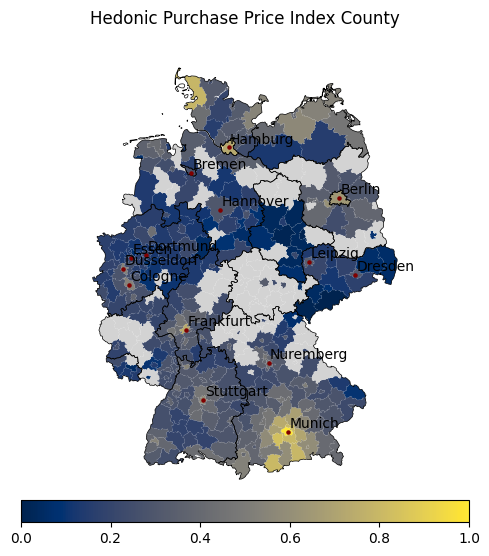

In [49]:
figure, axis = plt.subplots(1, 1, figsize=(5, 6)) 

gdf_germany_counties.plot(column='purchase_index', cmap='cividis',ax=axis, 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"}, # "edgecolor": "red", "hatch": "///", 
                          #scheme="quantiles", legend=True, legend_kwds=dict(loc='lower left', bbox_to_anchor=(0.05,-0.2), 
                          #ncol=2))
                          legend=True, legend_kwds={'orientation':'horizontal', "pad": 0})

gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis)

gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis)

for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Hedonic Purchase Price Index County')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/purchase_index.png', bbox_inches='tight')
else:
    plt.tight_layout()

---

## Task 3: Exogenous Factors <a class="anchor" id="exogenous_factors"></a>

Following the quantitative spatial equilibrium framework by Glaeser & Gottlieb (2009) we derive the exogenous factors for amenities $B_c$, productivities $A_c$, and land availability $M_c$ using the equilibrium conditions:

$$
log(w_c) = \Omega_1 + \frac{log(A_c)}{1−\beta} − \frac{1−\alpha−\beta}{1−\beta} log(L_c) + \frac{1−\alpha−\beta}{1−\beta} log(Z)
$$

$$
log(P_c) = \Omega_2 + \frac{\delta - 1}{\delta} [log(w_c) + log(L_c) − log(M_c)]
$$

$$
log(w_c) = \Omega_3 - log(B_c) + \sigma log(P_c) 
$$

Since $\Omega_1$, $\Omega_2$, and $\Omega_3$ are constant values that do not vary on the county level, we set them equal to zero. 

### (a) Quality-of-Life Index <a class="anchor" id="quality_life"></a>

Since we assume the expenditure share of housing $\sigma$ is one-third, we can solve the indifference condition for $B_c$:  

$$
log(B_c) = \Omega_3 + \sigma log(P_c) - log(w_c) 
\quad\Leftrightarrow \quad 
B_c = \exp( \frac{P_c^{\sigma}}{w_c})
$$

In [50]:
expenditure_share = 1/3

gdf_germany_counties['qol_rent_no_qualification'] = np.exp(gdf_germany_counties['rent_index'] ** expenditure_share/ gdf_germany_counties['wage_no_qualification'])
gdf_germany_counties['qol_rent_professional'] = np.exp(gdf_germany_counties['rent_index'] ** expenditure_share/ gdf_germany_counties['wage_professional'])
gdf_germany_counties['qol_rent_academic'] = np.exp(gdf_germany_counties['rent_index'] ** expenditure_share/ gdf_germany_counties['wage_academic'])

gdf_germany_counties['qol_purchase_no_qualification'] = np.exp(gdf_germany_counties['purchase_index'] ** expenditure_share/ gdf_germany_counties['wage_no_qualification'])
gdf_germany_counties['qol_purchase_professional'] = np.exp(gdf_germany_counties['purchase_index'] ** expenditure_share/ gdf_germany_counties['wage_professional'])
gdf_germany_counties['qol_purchase_academic'] = np.exp(gdf_germany_counties['purchase_index'] ** expenditure_share/ gdf_germany_counties['workers_academic'])

## Get ranking by sorting and reseting the index
list_qol_index = ['qol_rent_no_qualification', 'qol_rent_professional', 'qol_rent_academic', 
                     'qol_purchase_no_qualification', 'qol_purchase_professional', 'qol_purchase_academic']
for i in list_qol_index:
    gdf_germany_counties[i] = normalize_min_max(gdf_germany_counties[i])
    #gdf_germany_counties[i] = gdf_germany_counties[i].rank(method='max')

In [51]:
## Quality of Life based on Rent Prices

df_display = pd.concat([
        gdf_germany_counties.sort_values('qol_rent_no_qualification', ascending=False)[['county_name']].reset_index(drop=True).head(10),
        gdf_germany_counties.sort_values('qol_rent_professional', ascending=False)[['county_name']].reset_index(drop=True).head(10),
        gdf_germany_counties.sort_values('qol_rent_academic', ascending=False)[['county_name']].reset_index(drop=True).head(10)], axis=1)
df_display.columns = ['No Qualification (Rent)', 'Professional (Rent)', 'Academic (Rent)']
df_display

# print(tabulate(
#     pd.concat([
#         gdf_germany_counties.sort_values('qol_rent_no_qualification', ascending=False)[['county_name']].reset_index(drop=True).head(10),
#         gdf_germany_counties.sort_values('qol_rent_professional', ascending=False)[['county_name']].reset_index(drop=True).head(10),
#         gdf_germany_counties.sort_values('qol_rent_academic', ascending=False)[['county_name']].reset_index(drop=True).head(10)], axis=1).values,
#     headers=['No Qualification', 'Professional', 'Academic'], tablefmt='orgtbl'))

,No Qualification (Rent),Professional (Rent),Academic (Rent)
0,Potsdam,Dahme-Spreewald,Garmisch-Partenkirchen
1,Dahme-Spreewald,Potsdam-Mittelmark,Dahme-Spreewald
2,Garmisch-Partenkirchen,Havelland,Havelland
3,Dachau,Märkisch-Oderland,Märkisch-Oderland
4,Potsdam-Mittelmark,Oberhavel,Aichach-Friedberg
5,Teltow-Fläming,Barnim,Ebersberg
6,Rosenheim,Miesbach,Barnim
7,Oberhavel,Garmisch-Partenkirchen,Freiburg im Breisgau
8,Ebersberg,Potsdam,Potsdam
9,Offenbach am Main,Ostholstein,Dachau


In [52]:
## Quality of Life based on Purchase Prices

df_display = pd.concat([
        gdf_germany_counties.sort_values('qol_purchase_no_qualification', ascending=False)[['county_name']].reset_index(drop=True).head(10),
        gdf_germany_counties.sort_values('qol_purchase_professional', ascending=False)[['county_name']].reset_index(drop=True).head(10),
        gdf_germany_counties.sort_values('qol_purchase_academic', ascending=False)[['county_name']].reset_index(drop=True).head(10)], axis=1)
df_display.columns = ['No Qualification (Purchase)', 'Professional (Purchase)', 'Academic (Purchase)']
df_display

# print(tabulate(
#     pd.concat([
#         gdf_germany_counties.sort_values('qol_purchase_no_qualification', ascending=False)[['county_name']].reset_index(drop=True).head(10),
#         gdf_germany_counties.sort_values('qol_purchase_professional', ascending=False)[['county_name']].reset_index(drop=True).head(10),
#         gdf_germany_counties.sort_values('qol_purchase_academic', ascending=False)[['county_name']].reset_index(drop=True).head(10)], axis=1).values,
#     headers=['No Qualification', 'Professional', 'Academic'], tablefmt='orgtbl'))

,No Qualification (Purchase),Professional (Purchase),Academic (Purchase)
0,Vorpommern-Rügen,Rostock,Wittmund
1,Garmisch-Partenkirchen,Vorpommern-Rügen,Schwabach
2,Nordfriesland,Nordfriesland,Neustadt an der Weinstraße
3,Vorpommern-Greifswald,Vorpommern-Greifswald,Kaufbeuren
4,Rostock,Garmisch-Partenkirchen,Bayreuth
5,Potsdam,Miesbach,Fürth
6,Dachau,Ostholstein,Delmenhorst
7,Ebersberg,Potsdam,Plön
8,Rosenheim,Nordwestmecklenburg,Friesland
9,Miesbach,Dachau,Garmisch-Partenkirchen


In [53]:
gdf_germany_counties.sort_values('qol_purchase_no_qualification', ascending=False).loc[gdf_germany_counties['county_name'] == 'München']

,county_id,county_name,population,county_area,geometry,workers_no_qualification,wage_no_qualification,workers_professional,wage_professional,workers_academic,wage_academic,rent_index,purchase_index,qol_rent_no_qualification,qol_rent_professional,qol_rent_academic,qol_purchase_no_qualification,qol_purchase_professional,qol_purchase_academic
223,9162.0,München,1484226.0,310.70,"POLYGON ((689101.112 5344817.016, 689154.371 5...",46220.0,3094.374644,261650.0,4213.039936,292230.0,6250.395920,1.000000,1.000000,0.902633,0.828564,0.883305,0.858141,0.779397,0.003929
238,9184.0,München,350473.0,664.26,"POLYGON ((691855.982 5351910.135, 692004.736 5...",11953.0,3002.372247,83603.0,4106.779398,74831.0,6327.652642,0.890239,0.798283,0.894928,0.817690,0.839349,0.820445,0.741713,0.014233


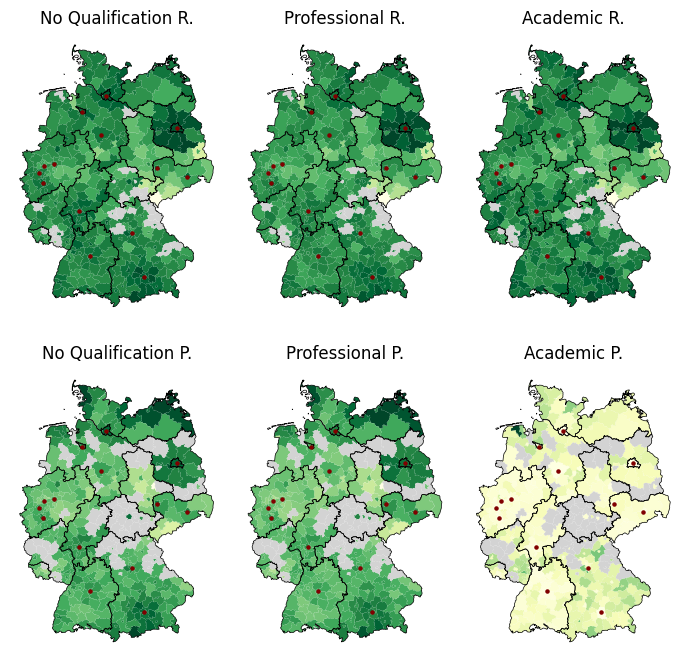

In [54]:
list_qol_index = ['qol_rent_no_qualification', 'qol_rent_professional', 'qol_rent_academic', 
                     'qol_purchase_no_qualification', 'qol_purchase_professional', 'qol_purchase_academic']

list_qol_display = ['No Qualification R.', 'Professional R.', 'Academic R.', 
                    'No Qualification P.', 'Professional P.', 'Academic P.']

figure, axis = plt.subplots(2, 3, figsize=(7, 7)) 

for i, ax in enumerate(axis.flat):    
    gdf_germany_counties.plot(column=list_qol_index[i], cmap='YlGn', ax=ax, #scheme="quantiles",
                              missing_kwds={"color": "lightgrey", "label": "Missing values"})
    gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=ax)
    gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=ax)

    # for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    #     ax.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)
    
    ax.set_title(list_qol_display[i])
    ax.set_axis_off()
    
if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/quality_of_life.png', bbox_inches='tight')
else:
    plt.tight_layout()

After plotting, here’s what we find:

- Quality of Life in capital cities is high across skill groups and price indices
- Alpine region is really popular as well as Northern Germany boarding the Nordic and the Baltic Sea
- Though workers with a academic degree are less favorable in buying property within cities and rather settle in the suburbs 
- Also people who rent have an increased valuation of the France and Swiss boarder region

---

### (b) Fundamental productivity

Since we assume the expenditure share of labour $\alpha$ is two-thirds, we can rearrange the general equilibrium condition wrt $A_c$:

$$
log(L_c) = \Omega_1 \frac{1−\beta}{1−\alpha−\beta} + log(\overline{Z}) - \frac{1−\beta}{1−\alpha−\beta} log(w_c) + \frac{1}{1−\alpha−\beta} log(A_c)
$$

Calculate the share of capital by estimating and rearranging the coefficient:

$$
\beta = \frac{\eta - \eta \alpha - 1}{\eta - 1} 
$$

In [70]:
gdf_germany_counties['wage_average'] = (
    gdf_germany_counties['wage_no_qualification'] * gdf_germany_counties['workers_no_qualification'] + 
    gdf_germany_counties['wage_professional'] * gdf_germany_counties['workers_professional'] + 
    gdf_germany_counties['wage_academic'] * gdf_germany_counties['workers_academic']) / (
        gdf_germany_counties['workers_no_qualification'] + 
        gdf_germany_counties['workers_professional'] + 
        gdf_germany_counties['workers_academic'])

gdf_germany_counties['workers'] = (
        gdf_germany_counties['workers_no_qualification'] + 
        gdf_germany_counties['workers_professional'] + 
        gdf_germany_counties['workers_academic'])

In [71]:
list_qol_index = ['qol_rent_no_qualification', 'qol_rent_professional', 'qol_rent_academic', 
                     'qol_purchase_no_qualification', 'qol_purchase_professional', 'qol_purchase_academic']

gdf_germany_counties['qol_average'] = normalize_min_max(gdf_germany_counties[list_qol_index].sum(axis=1))

In [72]:
from statsmodels.sandbox.regression.gmm import IV2SLS

data_regression = gdf_germany_counties[['wage_average', 'workers', 'qol_average']].dropna()

data_regression[['workers', 'wage_average']] = np.log(data_regression[['workers', 'wage_average']])

exog = sm.add_constant(data_regression[['qol_average', 'wage_average']])
endog = data_regression[['workers']]

# Alternatively, you can use IV2SLS directly
iv_model = IV2SLS(endog, exog[['const', 'wage_average']], instrument=exog[['const', 'qol_average']])
iv_results = iv_model.fit()

print(iv_results.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                workers   R-squared:                       0.097
Model:                         IV2SLS   Adj. R-squared:                  0.095
Method:                     Two Stage   F-statistic:                     44.37
                        Least Squares   Prob (F-statistic):           9.18e-11
Date:                Fri, 25 Apr 2025                                         
Time:                        14:29:42                                         
No. Observations:                 396                                         
Df Residuals:                     394                                         
Df Model:                           1                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -32.0528      6.388     -5.018   

In [86]:
import statsmodels.api as sm

data_regression = gdf_germany_counties[['wage_average', 'workers']].dropna()

X = sm.add_constant(np.log(data_regression['wage_average']))
y = np.log(data_regression['workers'])

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                workers   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     132.3
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           1.37e-26
Time:                        15:24:57   Log-Likelihood:                -376.29
No. Observations:                 396   AIC:                             756.6
Df Residuals:                     394   BIC:                             764.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -13.3678      2.075     -6.441   

In [136]:
## Calculate the share of capital 

alpha = 2/3

#beta = (1 + (1 - alpha) * (iv_results.params[1])) / (1 + iv_results.params[1])
beta = (iv_results.params[1] - iv_results.params[1] * alpha - 1) / (iv_results.params[1] - 1)

## Calculate the productivity index

gdf_germany_counties['productivity_index'] = np.exp(iv_results.resid * (1 - alpha - beta))
# gdf_germany_counties['productivity_index'] = np.exp(
#     (y - model.params[0] - model.params[1] * np.log(data_regression['wage_average']) ) / model.params[1] *(1-beta)
# )

gdf_germany_counties['productivity_index'] = normalize_min_max(gdf_germany_counties['productivity_index'])

print('= {}'.format(beta))

= 0.17420243757877182


In [137]:
df_display = pd.concat([
        gdf_germany_counties.sort_values('productivity_index', ascending=False)[['county_name']].reset_index(drop=True).head(10).reset_index(drop=True),
        gdf_germany_counties.sort_values('productivity_index', ascending=False)[['county_name']].reset_index(drop=True).tail(10).reset_index(drop=True)], axis=1)
df_display.columns = ['Productivity Index Top 10', 'Productivity Index Bottom 10']
df_display

,Productivity Index Top 10,Productivity Index Bottom 10
0,Berlin,Ingolstadt
1,Erzgebirgskreis,Erlangen
2,Hamburg,Zweibrücken
3,Mittelsachsen,Frankenthal (Pfalz)
4,Region Hannover,Salzgitter
5,Leipzig,Lüchow-Dannenberg
6,Bautzen,Suhl
7,Görlitz,Weimar
8,Zwickau,Eisenach
9,Vogtlandkreis,Kyffhäuserkreis


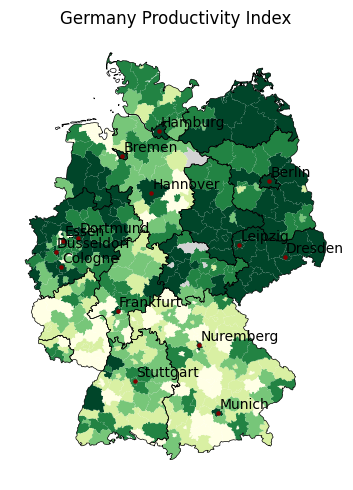

In [138]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5)) 

gdf_germany_counties.plot(column='productivity_index', cmap='YlGn',ax=axis, 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"}, # "edgecolor": "red", "hatch": "///", 
                          scheme="quantiles", legend=False, legend_kwds=dict(loc='lower left', bbox_to_anchor=(0.05,-0.2), 
                          ncol=1))

gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis)

gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis)

for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Germany Productivity Index')

plt.tight_layout()

After plotting, here’s what we find:

- High productivity in large cities like Munich, Berlin, etc. and in industrial regional like the Ruhr area
- Would imagine a higher productivity in Bavaria and Baden-Wuerttemberg in comparison to Brandenburg

Comments: 

- Different technologies across sectors (retail industry in Berlin vs steal industry Ruhr area)

---

### (c) Effective land supply

Since we assume a height elasticity of construction cost $\delta$ of 1.5, we can solve the general equilibrium condition for $M_c$:

$$
log(M_c) = log(w_c) + log(L_c) - \frac{\delta}{\delta-1} [log(P_c) - \Omega_2]
\quad \Leftrightarrow \quad
M_c = \frac{w_c L_c}{P_c^{\frac{\delta}{\delta-1}}}
$$

$$

$$

where $\frac{\delta}{\delta-1}$ is defined as $\epsilon$, the height elasticity of construction cost.

In [86]:
delta = 1.5

gdf_germany_counties['effective_land_supply'] = np.log(gdf_germany_counties['rent_index']) * (delta/(delta-1)) - np.log(gdf_germany_counties['wage_average']) - np.log(gdf_germany_counties['workers'])

# gdf_germany_counties['effective_land_supply'] = np.exp(
#     gdf_germany_counties['wage_average'] * gdf_germany_counties['workers'] / (gdf_germany_counties['rent_index'] ** (delta/(delta-1)))
# )

gdf_germany_counties['effective_land_supply'] = np.log(gdf_germany_counties['rent_index']) * (delta/(delta-1)) - np.log(gdf_germany_counties['wage_average']) - np.log(gdf_germany_counties['workers'])
gdf_germany_counties['effective_land_supply'].replace([np.inf, -np.inf], np.nan, inplace=True)
gdf_germany_counties['effective_land_supply'] = normalize_min_max(gdf_germany_counties['effective_land_supply'])

In [87]:
df_display = pd.concat([
        gdf_germany_counties.sort_values('effective_land_supply', ascending=False)[['county_name']].reset_index(drop=True).head(10).reset_index(drop=True),
        gdf_germany_counties.sort_values('effective_land_supply', ascending=False)[['county_name']].reset_index(drop=True).tail(10).reset_index(drop=True)], axis=1)
df_display.columns = ['Productivity Index Top 10', 'Productivity Index Bottom 10']
df_display

,Productivity Index Top 10,Productivity Index Bottom 10
0,Garmisch-Partenkirchen,Schweinfurt
1,Miesbach,St. Wendel
2,Ebersberg,Vogtlandkreis
3,Dachau,Suhl
4,Bad Tölz-Wolfratshausen,Weimar
5,Fürstenfeldbruck,Eisenach
6,Starnberg,Kyffhäuserkreis
7,Rosenheim,Hildburghausen
8,Lindau (Bodensee),Saalfeld-Rudolstadt
9,Neustadt an der Weinstraße,Saale-Orla-Kreis


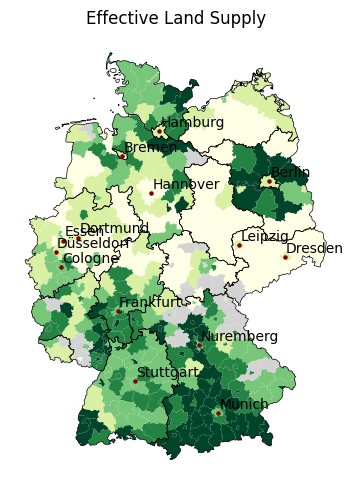

In [88]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5)) 

gdf_germany_counties.plot(column='effective_land_supply', cmap='YlGn',ax=axis, 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"}, # "edgecolor": "red", "hatch": "///", 
                          scheme="quantiles", legend=False, legend_kwds=dict(loc='lower left', bbox_to_anchor=(0.05,-0.2), 
                          ncol=1))

gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis)

gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis)

for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Effective Land Supply')

plt.tight_layout()

After plotting, here’s what we find:

- Urban counties (e.g., Berlin, Munich) likely have low $M_c$ $\rightarrow$ high prices, dense development
- Rural counties may show higher $M_c$ $\rightarrow$ abundant land, lower prices
- Topographic constraints (e.g., in Alpine regions) may show artificially low land supply
- Pattern is less evident in Eastern Germany

### Alternative Measure of Effective Land Supply

Instead of building height use density (construction costs per square meter): 

$$
M_c = \frac{(L_c / Area_c)}{P_c^\epsilon} = \frac{(Density_c)}{P_c^\epsilon}
$$

In [113]:
epsilon = 1

gdf_germany_counties['density'] = gdf_germany_counties['workers'] / gdf_germany_counties['county_area'] / 1e6
# gdf_germany_counties['M_c'] = (gdf_germany_counties['density'] ** epsilon) / gdf_germany_counties['rent_index']

gdf_germany_counties['effective_land_supply'] = (gdf_germany_counties['density']) / gdf_germany_counties['rent_index']** epsilon

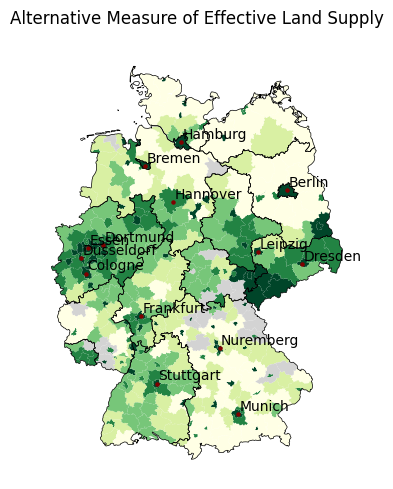

In [114]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5)) 

gdf_germany_counties.plot(column='effective_land_supply', cmap='YlGn',ax=axis, 
                          missing_kwds={"color": "lightgrey", "label": "Missing values"}, # "edgecolor": "red", "hatch": "///", 
                          scheme="quantiles", legend=False, legend_kwds=dict(loc='lower left', bbox_to_anchor=(0.05,-0.2), 
                          ncol=1))

gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis)

gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis)

for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Alternative Measure of Effective Land Supply')

plt.tight_layout()

### Bonus Question 

Can you think of a theory-consistent way of estimating the height elasticity of construction cost?

If we already solved for $M_c$, we can regress log prices on a composite index of wages, population and land availability which yields the coefficient $\beta = \frac{\delta - 1}{\delta}$. Solving for $\delta$ yields the height elasticity of construction cost.

$$
log(P_c) = \Omega_2 + \frac{\delta - 1}{\delta} [log(w_c) + log(L_c) − log(M_c)]
$$

Alternatively, one could use additional information on building heights and run the following regression:

$$
log(D_c) = \underbrace{ - \frac{\delta}{1 - \delta} log(d_0) }_{\text{Constant}} 
+ \underbrace{ \frac{1}{1 - \delta} }_{\text{Elasticity}} log(P_c) 
$$

Either use rent or purchase index and subsequently solve for $\delta$.

In [115]:
## Alternatively housing demand

import statsmodels.api as sm

# log(Rent) = constant + ε * log(Density) + u
X = sm.add_constant(np.log(gdf_germany_counties[['density', 'rent_index']]).replace([np.inf, -np.inf], np.nan).dropna())
y = X.pop('rent_index')

model = sm.OLS(y, X).fit()
print(model.summary())

estimated_epsilon = model.params['density']

                            OLS Regression Results                            
Dep. Variable:             rent_index   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     52.70
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           2.25e-12
Time:                        22:51:20   Log-Likelihood:                -347.01
No. Observations:                 378   AIC:                             698.0
Df Residuals:                     376   BIC:                             705.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5784      0.236      2.449      0.0

---

## Appendix <a class="anchor" id="appendix"></a>

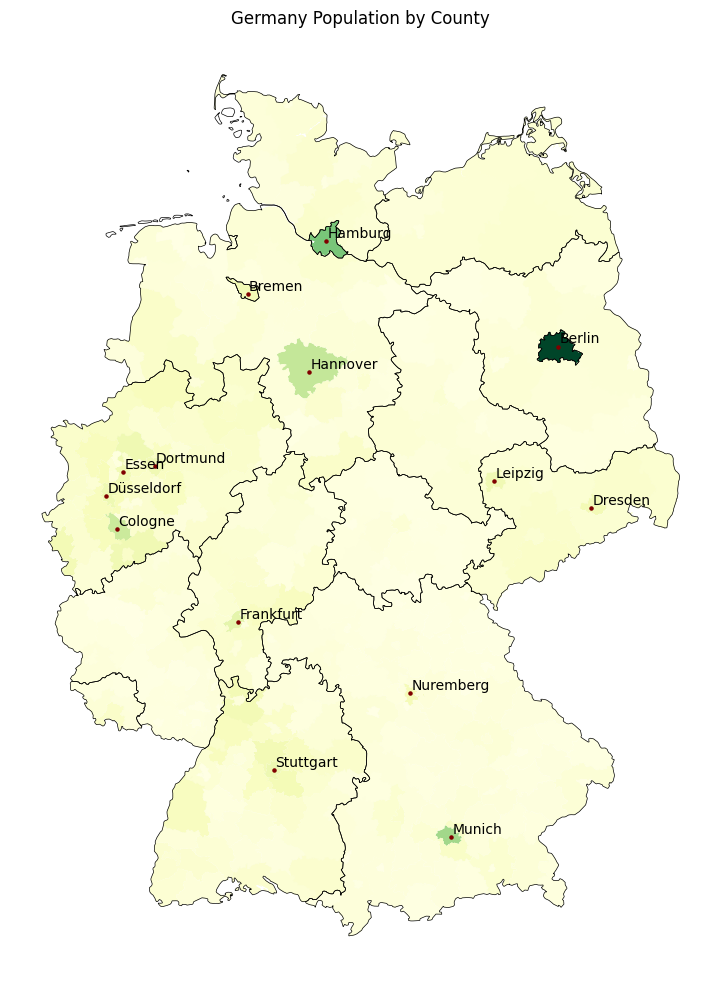

In [ ]:
figure, axis = plt.subplots(1, 1, figsize=(10, 10)) 

gdf_germany_counties.plot(column='population', cmap='YlGn',ax=axis)

gdf_germany_states.plot(facecolor='none', edgecolor='black', linewidth=0.5, ax=axis)

gdf_germany_cities_large.plot(marker='o', color='maroon', markersize=5, ax=axis)

for x, y, label in zip(gdf_germany_cities_large.geometry.x, gdf_germany_cities_large.geometry.y, gdf_germany_cities_large.city):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Germany Population by County')

plt.tight_layout()

## References

- [GitHub AHS2023-toolkit](#https://github.com/Ahlfeldt/AHS2023-toolkit/tree/main/APPLICATIONS/DATA/OUTPUT)
- ...
- ...

---